In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
def load_dataset(image_dir, mask_dir, img_size=(416, 416)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '.mask.png'))
            
            image = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
            
            images.append(img_to_array(image))
            masks.append(img_to_array(mask))
    
    images = np.array(images) / 255.0
    masks = np.array(masks) / 255.0
    return images, masks


In [3]:
image_dir = 'myfolder/images'
mask_dir = 'myfolder/masks'
images, masks = load_dataset(image_dir, mask_dir)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def yolo_model(input_shape=(416, 416, 3)):
    inputs = Input(shape=input_shape)
    
    # Downsampling
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = yolo_model()


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [6]:
# Train the model
model.fit(images_train, masks_train, epochs=20, batch_size=8, validation_data=(images_test, masks_test))


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9836 - loss: 0.0432 - val_accuracy: 0.9896 - val_loss: 0.0289
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9877 - loss: 0.0325 - val_accuracy: 0.9897 - val_loss: 0.0300
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9867 - loss: 0.0352 - val_accuracy: 0.9907 - val_loss: 0.0229
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9878 - loss: 0.0322 - val_accuracy: 0.9909 - val_loss: 0.0229
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9837 - loss: 0.0448 - val_accuracy: 0.9905 - val_loss: 0.0232
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9879 - loss: 0.0324 - val_accuracy: 0.9908 - val_loss: 0.0221
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9885 - loss: 0.0297 - val_accuracy: 0.9901 - val_loss: 0.0241
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9894 - loss: 0.0272 - val_accu

: 

In [ ]:
model.save('YOLO-10epoch.h5')

In [6]:
from tensorflow.keras.models import load_model 
# Load the model 
model = load_model('YOLO-9.82epoch.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


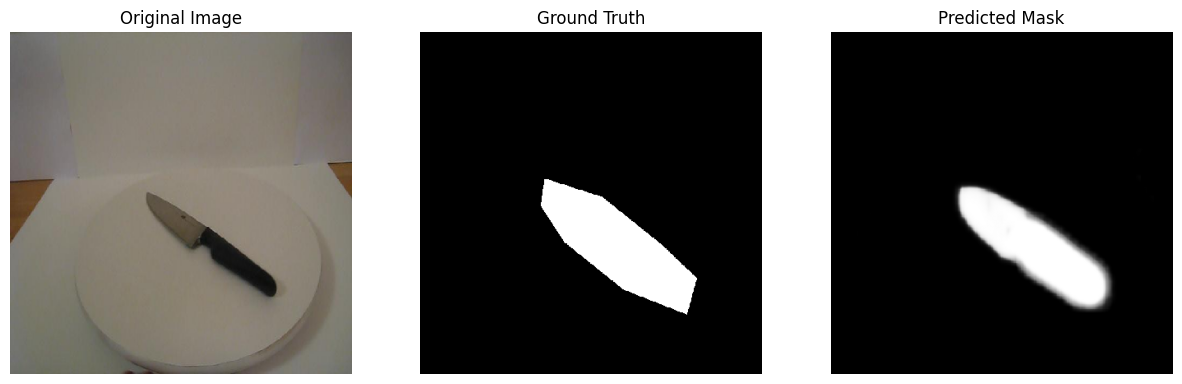

In [7]:
import matplotlib.pyplot as plt

# Select a test image
index = 0  # Change the index to visualize different test images
test_image = images_test[index]
ground_truth = masks_test[index]

# Predict the mask
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot the original image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test_image)
axs[0].set_title('Original Image')

axs[1].imshow(ground_truth[:, :, 0], cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(predicted_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

for ax in axs:
    ax.axis('off')

plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Precision: 0.9762
Recall: 0.8380
F1-score: 0.9018
IoU: 0.8212


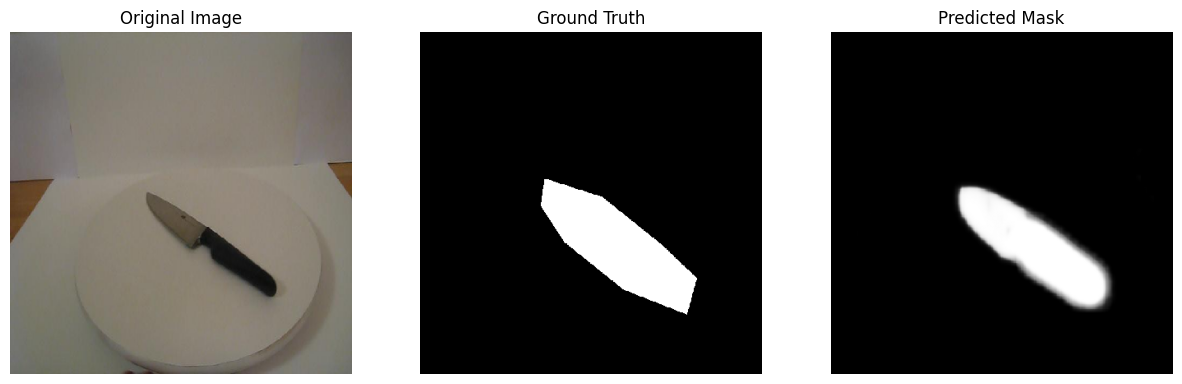

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate these metrics
def evaluate_metrics(true_mask, pred_mask, threshold=0.5):
    pred_mask = pred_mask > threshold
    true_mask = true_mask.astype(np.uint8).flatten()
    pred_mask = pred_mask.astype(np.uint8).flatten()
    
    precision = precision_score(true_mask, pred_mask)
    recall = recall_score(true_mask, pred_mask)
    f1 = f1_score(true_mask, pred_mask)
    iou = np.sum(np.logical_and(pred_mask, true_mask)) / np.sum(np.logical_or(pred_mask, true_mask))

    return precision, recall, f1, iou

# Select a test image
index = 0  # Change the index to visualize different test images
test_image = images_test[index]
ground_truth = masks_test[index]

# Predict the mask
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Evaluate the metrics
precision, recall, f1, iou = evaluate_metrics(ground_truth, predicted_mask)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

# Plot the original image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test_image)
axs[0].set_title('Original Image')

axs[1].imshow(ground_truth[:, :, 0], cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(predicted_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

for ax in axs:
    ax.axis('off')

plt.show()
